# Fitting procedures and heavy computations notebook

## imports and setup

In [17]:
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pickle
from scipy import stats

from sessionlists import (dist60, dist90, dist120, TM20, TM10, TM2, TMrev2, TMrev10, TMrev20)
from utils import *
from plotting import *
from model_functions import *

plt.style.use('./Figures/paper.mplstyle')

In [18]:
# Define folder with data
root = "/home/thomas/Desktop/ALLDATA"

print("Path to data is: %s"%root)
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/thomas/Desktop/ALLDATA
Found 34 rats in the data folder


## rat colors and reload pickled data

In [47]:
rat_markers = {}
params = {}
sequence = {}
XtrackRunToLeftBin = {}
XtrackRunToRightBin = {}

# RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

intact_rats = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

lesioned_rats = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42',
            'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52']


m, f, l = 0, 0, 0
male_palette = create_teal_palette(num_shades=len([x for x in intact_rats if 'M' in x]))
female_palette = create_blue_violet_palette(num_shades=len([x for x in intact_rats if 'F' in x]), start_intensity=80)
palette = create_kiwi_green_palette(num_shades=len(lesioned_rats))
for index, animal in enumerate(intact_rats):
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[female_palette[f], 'o', '-']
        f += 1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[male_palette[m], 'o', '-']
        m += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in processData.ipynb
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        # get the preprocessed data from the pickle files
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p")
        params[animal, session]     = get_from_pickle(root, animal[0:6], session, name="params.p")
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="trackPos.p")


for index, animal in enumerate(lesioned_rats):
    if fnmatch.fnmatch(animal, 'Rat*'):
        rat_markers[animal]=[palette[l], 'o']
        l += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p")
        params[animal, session]     = get_from_pickle(root, animal[0:6], session, name="params.p")
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="trackPos.p")


## bin the data (10min time bins and with reward history)

In [20]:
# separate the data into time and reward bins for each experimental condition
# distances 
data60IDLE = prepare_data_idle_times(sequence, animalList, dist60)
data90IDLE = prepare_data_idle_times(sequence, animalList, dist90)
data120IDLE = prepare_data_idle_times(sequence, animalList, dist120)

data60RUN = prepare_data_running_times(sequence, animalList, dist60)
data90RUN = prepare_data_running_times(sequence, animalList, dist90)
data120RUN = prepare_data_running_times(sequence, animalList, dist120)

# treadmill speeds
data20IDLE = prepare_data_idle_times(sequence, animalList, TM20)
data10IDLE = prepare_data_idle_times(sequence, animalList, TM10)
data2IDLE = prepare_data_idle_times(sequence, animalList, TM2+TMrev2)
datarev10IDLE = prepare_data_idle_times(sequence, animalList, TMrev10)
datarev20IDLE = prepare_data_idle_times(sequence, animalList, TMrev20)

data20RUN = prepare_data_running_times(sequence, animalList, TM20)
data10RUN = prepare_data_running_times(sequence, animalList, TM10)
data2RUN = prepare_data_running_times(sequence, animalList, TM2+TMrev2)
datarev10RUN = prepare_data_running_times(sequence, animalList, TMrev10)
datarev20RUN = prepare_data_running_times(sequence, animalList, TMrev20)

# all conditions pooled
dataAllIDLE = prepare_data_idle_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)
dataAllRUN = prepare_data_running_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)


# Fit model parameters ($α_0$, $α_t$, $α_u$, $γ_0$, $γ_t$, $γ_u$, $μ_0$, $μ_t$, $μ_u$, $σ_0$, $σ_u$ and $σ_u$)

In [21]:
# fit the model to the data, reload if already done
if os.path.exists("picklejar/ModelsFitsAllRats.p"):
    alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U, mu, mu_t, mu_U, sigma, sigma_t, sigma_U = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
else:

    alpha_t_fixed, gamma_t_fixed, alpha_U_fixed, gamma_U_fixed = False, False, False, False
    mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed = False, False, False, False

    alpha, gamma, alpha_t, gamma_t, alpha_U, gamma_U, lossWald = {}, {}, {}, {}, {}, {}, {}
    mu, mu_t, mu_U, sigma, sigma_t, sigma_U, loss = {}, {}, {}, {}, {}, {}, {}

    for animal in animalList:
        print(animal)
        alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

        mu[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        loss[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


        for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60IDLE, data90IDLE, data120IDLE, data20IDLE, data10IDLE, data2IDLE, datarev10IDLE, datarev20IDLE]):
            (alpha[animal][cond], theta, gamma[animal][cond], \
            alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
            alpha_U[animal][cond], thetasecond, gamma_U[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                            gamma_t_fixed=gamma_t_fixed, 
                                                                                                                            alpha_U_fixed=alpha_U_fixed, 
                                                                                                                            gamma_U_fixed=gamma_U_fixed)

        for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60RUN, data90RUN, data120RUN, data20RUN, data10RUN, data2RUN, datarev10RUN, datarev20RUN]):
            (mu[animal][cond], sigma[animal][cond], \
            mu_t[animal][cond], sigma_t[animal][cond], \
            mu_U[animal][cond], sigma_U[animal][cond]), loss[animal][cond] = modelrun_fit(data[animal], f=modelrun_crit,
                                                                                        mu_t_fixed=mu_t_fixed, 
                                                                                                        sigma_t_fixed=sigma_t_fixed, 
                                                                                                        mu_U_fixed=mu_U_fixed, 
                                                                                                        sigma_U_fixed=sigma_U_fixed)
            print(mu[animal][cond], sigma[animal][cond], 
            mu_t[animal][cond], sigma_t[animal][cond], 
            mu_U[animal][cond], sigma_U[animal][cond], loss[animal][cond])

    pickle.dump([alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U, mu, mu_t, mu_U, sigma, sigma_t, sigma_U,], open("picklejar/ModelsFitsAllRats.p", "wb"))


## plot fit result

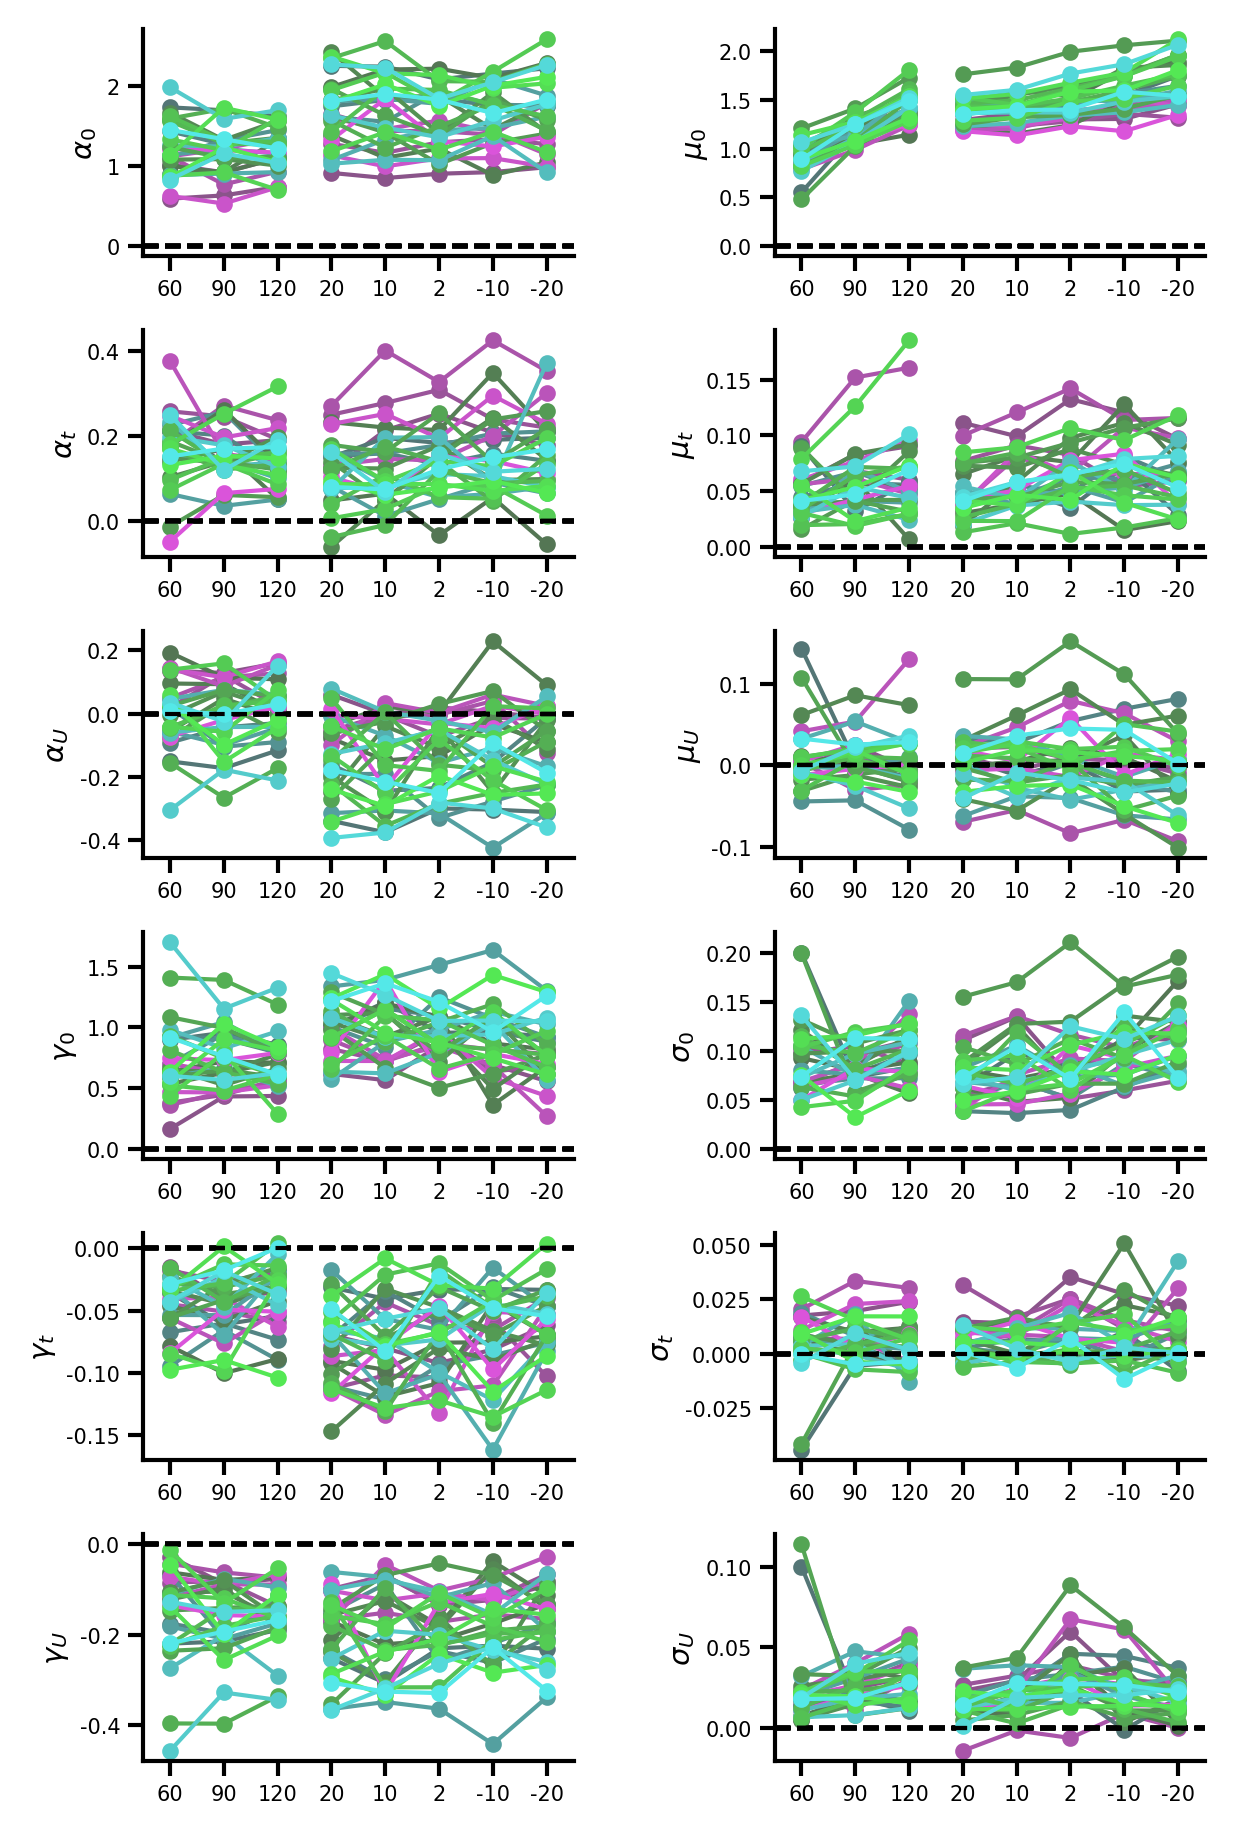

In [33]:
fig, axs = plt.subplots(6, 3, figsize=(4, 6), gridspec_kw={'width_ratios': [5, .1, 5]})
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_U$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_U$"]
ylimsIDLE = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_U$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_U$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .15], [-.05, .2], [-.05, .05], [-.025, .1], ]

varsIDLE = [alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U]
varsRUN = [mu, mu_t, mu_U, sigma, sigma_t, sigma_U, ]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=3)
        axs[i, 0].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=3)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(8))
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 7.5)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 2].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=3)
        axs[i, 2].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=3)
        axs[i, 2].set_title(f"")
        axs[i, 2].set_xticks(np.arange(8))
        axs[i, 2].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 2].set_ylabel(ylabel)
        axs[i, 2].set_xlim(-.5, 7.5)
        axs[i, 2].axhline(0, color='black', linestyle='--', linewidth=1)

for i in range(6):
    axs[i, 1].axis('off')


# Compute models loss with 1 to 8 trial history length

# Inter-run model

3.404040404040404


Text(0, 0.5, '$\\Sigma$ loss, norm')

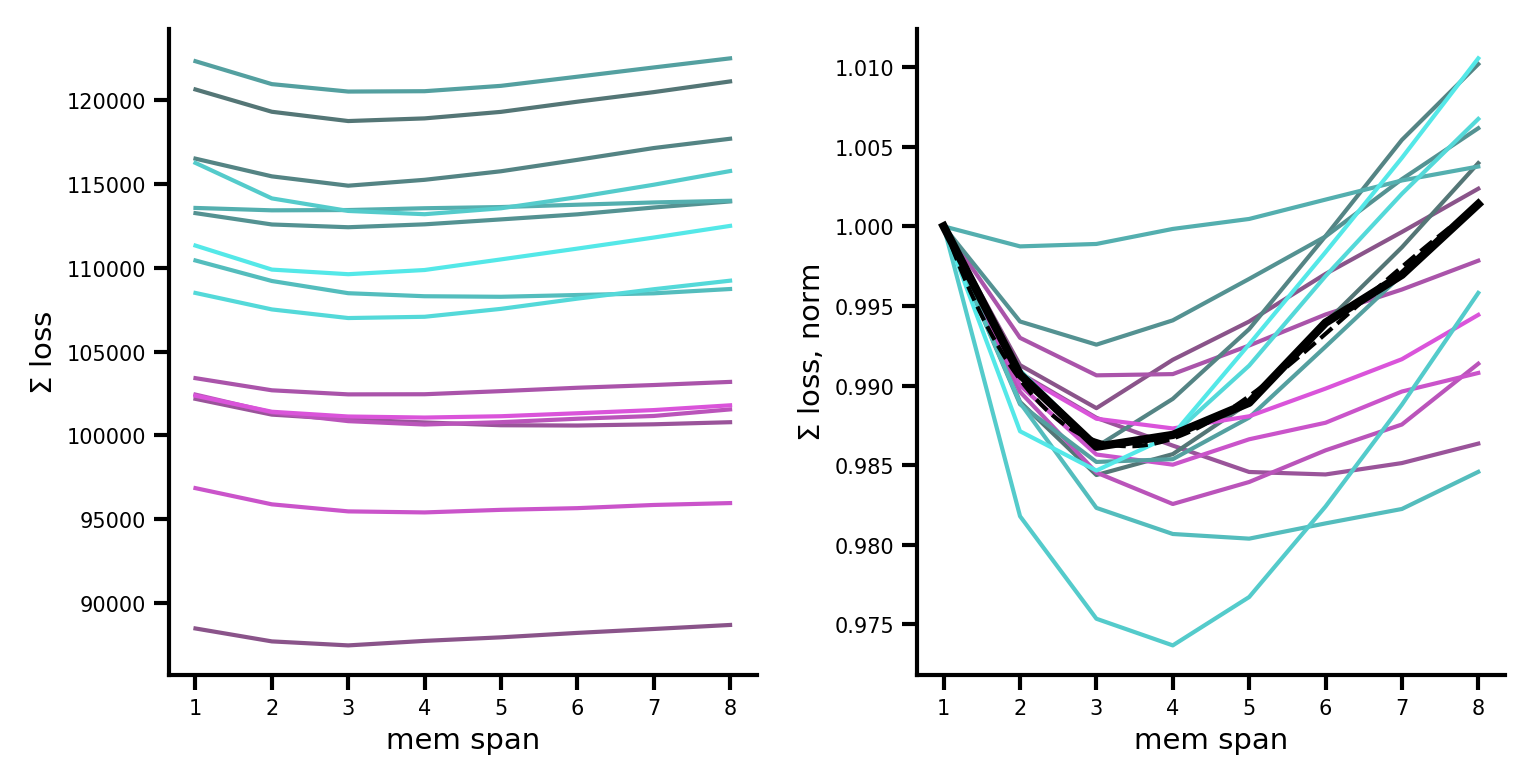

In [22]:
memsizes = np.arange(1, 9)

losses = {k:np.zeros(len(memsizes)) for k in intact_rats}
normalized_losses = {k:np.zeros(len(memsizes)) for k in intact_rats}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

if os.path.exists("picklejar/rewardHistoryLossInterRunDuration.p"):
    losses = pickle.load(open("picklejar/rewardHistoryLossInterRunDuration.p", "rb"))
else:
    for idx, memsize in enumerate(memsizes):
        data_all = prepare_data_idle_times(sequence, intact_rats, sessions, memsize=memsize, time_bins=6)
        for animal in intact_rats:
            p, losses[animal][idx] = modelwald_fit(data_all[animal], f=model_compare, N_bins=6, N_avg=len(meankeys(generate_targetList(seq_len=memsize)[::-1])))


fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))
for idx, animal in enumerate(intact_rats):
    axs[0].plot(memsizes, losses[animal], color=rat_markers[animal][0])
    axs[1].plot(memsizes, (losses[animal])/(losses[animal][0]), color=rat_markers[animal][0], label=animal)
    normalized_losses[animal] = (losses[animal])/(losses[animal][0])

median_losses = np.median(np.array(list(normalized_losses.values())), axis=0)
axs[1].plot(memsizes, median_losses, color='k', lw=2)
z = np.poly1d(np.polyfit(memsizes, median_losses, 4))
x=np.linspace(1, 8, 100)
axs[1].plot(x, z(x), color='k', ls='--')
print(x[np.argmin(z(x))])

axs[0].set_xlabel('mem span')
axs[1].set_xlabel('mem span')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')

## Run model

4.4646464646464645


Text(0, 0.5, '$\\Sigma$ loss, norm')

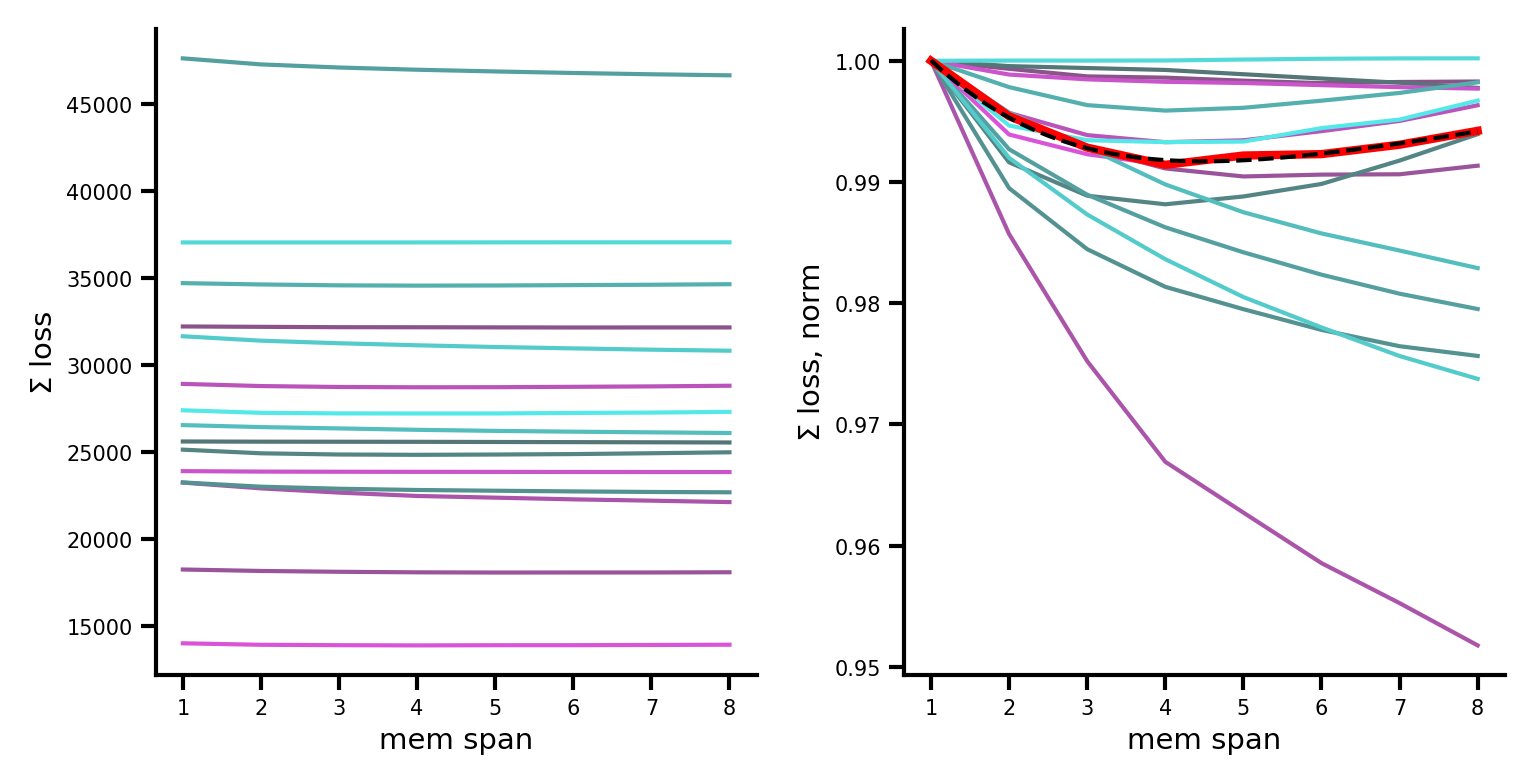

In [23]:
memsizes = np.arange(1, 9)

history_losses = {k:np.zeros(len(memsizes)) for k in intact_rats}
normalized_history_losses = {k:np.zeros(len(memsizes)) for k in intact_rats}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

if os.path.exists("picklejar/rewardHistoryLossRunDuration.p"):
    history_losses = pickle.load(open("picklejar/rewardHistoryLossRunDuration.p", "rb"))
else:
    for idx, memsize in enumerate(memsizes):
        print(f'Running for memsize {memsize}')
        data_all = prepare_data_running_times(sequence, intact_rats, sessions, memsize=memsize, time_bins=6)
        for animal in intact_rats:
            p, history_losses[animal][idx] = modelrun_fit(data_all[animal], f=modelrun_compare, N_bins=6, N_avg=len(meankeys(generate_targetList(seq_len=memsize)[::-1])))


fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))
for idx, animal in enumerate(intact_rats):
    axs[0].plot(memsizes, history_losses[animal], color=rat_markers[animal][0])
    axs[1].plot(memsizes, (history_losses[animal])/(history_losses[animal][0]), color=rat_markers[animal][0], label=animal)
    normalized_history_losses[animal] = (history_losses[animal])/(history_losses[animal][0])


median_losses = np.median(np.array(list(normalized_history_losses.values())), axis=0)
axs[1].plot(memsizes, median_losses, color='r', lw=2)
z = np.poly1d(np.polyfit(memsizes, median_losses, 4))
x=np.linspace(1, 8, 100)
axs[1].plot(x, z(x), color='k', ls='--')
print(x[np.argmin(z(x))])


axs[0].set_xlabel('mem span')
axs[1].set_xlabel('mem span')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')

# Model parameter ablation

## Inter-run model

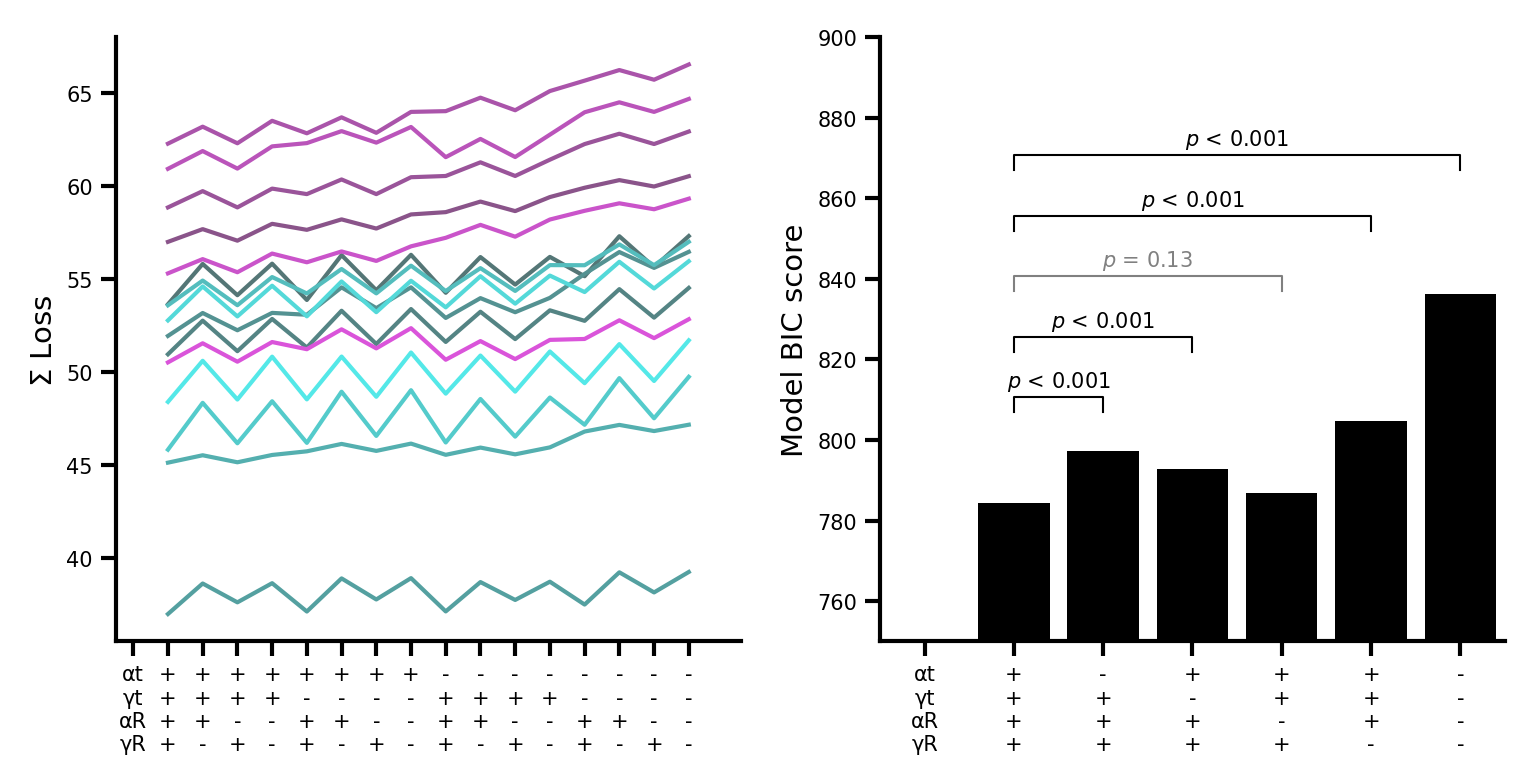

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]


if os.path.exists("picklejar/ablationLossesInterRunDuration.p"):
    ablation_losses = pickle.load(open("picklejar/ablationLossesInterRunDuration.p", "rb"))
else:
    ablation_losses = {}
    for animal in intact_rats:
        ablation_losses[animal] = {}
        for alpha_t_fixed in [False, True]:
            for gamma_t_fixed in [False, True]:
                for alpha_U_fixed in [False, True]:
                    for gamma_U_fixed in [False, True]:
                        number_of_params = 2  # alpha, gamma
                        number_of_extra_params = alpha_t_fixed+gamma_t_fixed+alpha_U_fixed+gamma_U_fixed
                        loss = modelwald_fit(dataAllIDLE[animal], 
                                            f=model_crit,
                                            alpha_t_fixed=alpha_t_fixed, 
                                            gamma_t_fixed=gamma_t_fixed, 
                                            alpha_U_fixed=alpha_U_fixed, 
                                            gamma_U_fixed=gamma_U_fixed, 
                                            N_params=number_of_params + (4 - number_of_extra_params),
                                            )[1]

                        ablation_losses[animal][(alpha_t_fixed, gamma_t_fixed, alpha_U_fixed, gamma_U_fixed)] = -loss
    pickle.dump(ablation_losses, open("picklejar/ablationLossesInterRunDuration.p", "wb"))

for animal in intact_rats:
    axs[0].plot(np.arange(16), [-l for l in ablation_losses[animal].values()], color=rat_markers[animal][0], label=animal)
    axs[0].set_ylabel(r'$\Sigma$ Loss')
    axs[0].set_xticks(np.arange(-1, 16))
    axs[0].set_xticklabels(dict_to_xticklabels(ablation_losses[animal], labels=['αt', 'γt', 'αR', 'γR']))
    axs[0].set_xlim([-1.5, 16.5])

    for i, key in enumerate(the_keys_i_want):
        axs[1].bar(i+1, -np.sum([ablation_losses[animal][key] for animal in intact_rats]), color='k', label='sum', )
    axs[1].set_ylabel('Model BIC score')
    axs[1].set_xticks(np.arange(7))
    axs[1].set_xticklabels(dict_to_xticklabels({k:ablation_losses[animal][k] for k in the_keys_i_want}, labels=['αt', 'γt', 'αR', 'γR']))
    axs[1].set_ylim([750, 900])
    axs[1].set_xlim([-.5, 6.5])
    axs[1].axhline(1, color='k', linestyle='--')


LLratio_vs_complete(ablation_losses, the_keys_i_want, intact_rats, axs[1])

## Run model

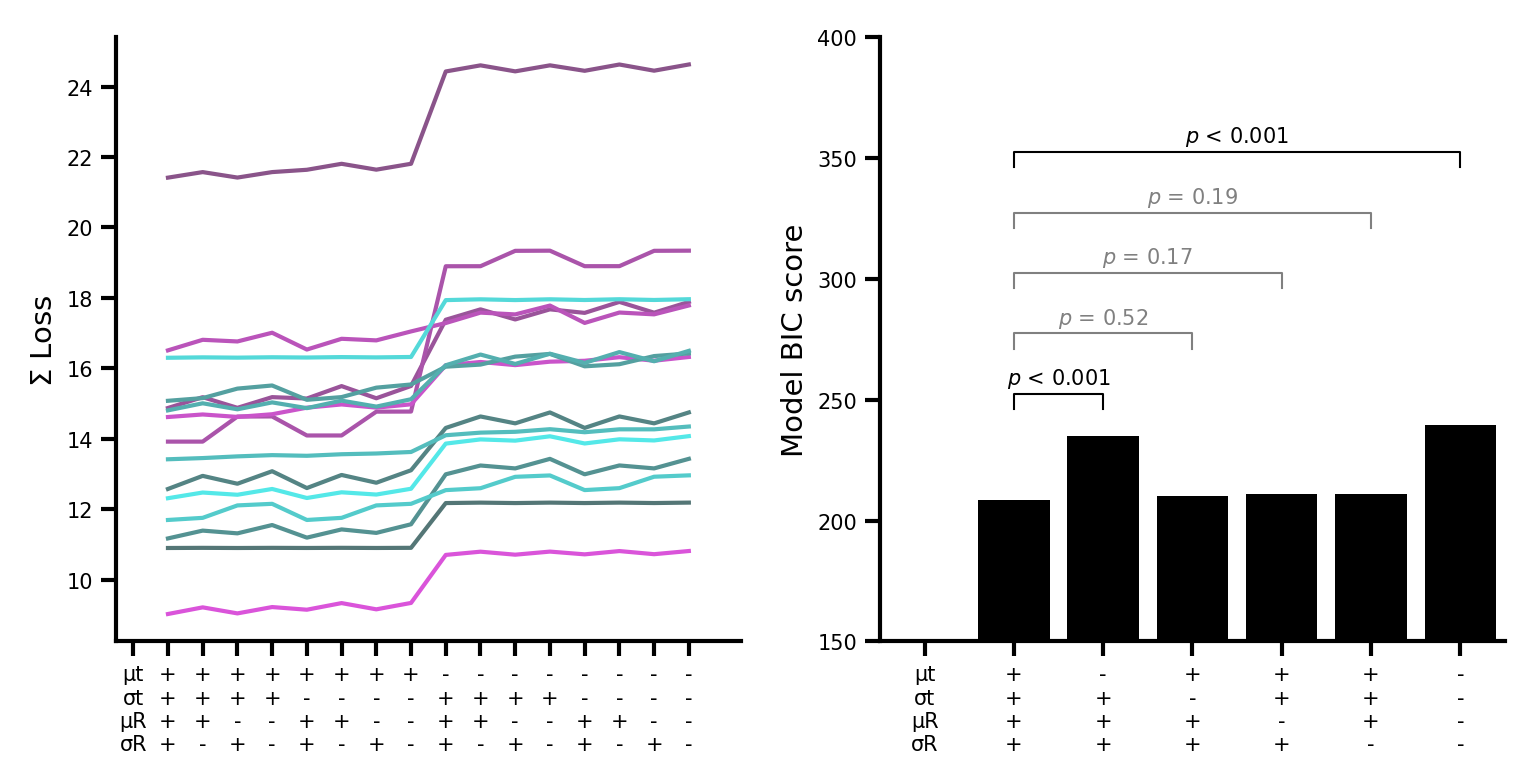

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

if os.path.exists("picklejar/ablationLossesRunDuration.p"):
    ablation_losses = pickle.load(open("picklejar/ablationLossesRunDuration.p", "rb"))
else:
    ablation_losses = {}
    for animal in intact_rats:
        ablation_losses[animal] = {}
        for mu_t_fixed in [False, True]:
            for sigma_t_fixed in [False, True]:
                for mu_U_fixed in [False, True]:
                    for sigma_U_fixed in [False, True]:
                        number_of_params = 2  # mu, sigma
                        number_of_extra_params = mu_t_fixed+sigma_t_fixed+mu_U_fixed+sigma_U_fixed
                        loss = modelrun_fit(dataAllRUN[animal],
                                            f=modelrun_crit,
                                            mu_t_fixed=mu_t_fixed, 
                                            sigma_t_fixed=sigma_t_fixed, 
                                            mu_U_fixed=mu_U_fixed, 
                                            sigma_U_fixed=sigma_U_fixed, 
                                            N_params=number_of_params + (4 - number_of_extra_params),
                                            )[1]

                        ablation_losses[animal][(mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed)] = -loss
        
    pickle.dump(ablation_losses, open("picklejar/ablationLossesRunDuration.p", "wb"))
    

for animal in intact_rats:
    axs[0].plot(np.arange(16), [-l for l in ablation_losses[animal].values()], color=rat_markers[animal][0], label=animal)
    axs[0].set_ylabel(r'$\Sigma$ Loss')
    axs[0].set_xticks(np.arange(-1, 16))
    axs[0].set_xticklabels(dict_to_xticklabels(ablation_losses[animal], labels=['μt', 'σt', 'μR', 'σR']))
    axs[0].set_xlim([-1.5, 16.5])

    for i, key in enumerate(the_keys_i_want):
        axs[1].bar(i+1, -np.sum([ablation_losses[animal][key] for animal in intact_rats]), color='k', label='sum', )
    axs[1].set_ylabel('Model BIC score')
    axs[1].set_xticks(np.arange(7))
    axs[1].set_xticklabels(dict_to_xticklabels({k:ablation_losses[animal][k] for k in the_keys_i_want}, labels=['μt', 'σt', 'μR', 'σR']))
    axs[1].set_ylim([150, 400])
    axs[1].set_xlim([-.5, 6.5])
    axs[1].axhline(1, color='k', linestyle='--')



LLratio_vs_complete(ablation_losses, the_keys_i_want, intact_rats, axs[1])

# Effort sensitivity ς0, ςt, ςu

## compute running distance

In [ ]:
realdist60 = {}
realdist90 = {}
realdist120= {}

# compute the running distance for each run (pos start - pos end) for each distance configuration
for animal in animalList:
    realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
    for session in sorted(matchsession(animal, dist60)):
        for i in range(0, 12):
            realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist90)):   
        for i in range(0, 12):
            realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist120)):
        for i in range(0, 12):
            realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])

# compute the mean running distance for each animal for each distance configuration
medianrealdist60 = {}
medianrealdist90 = {}
medianrealdist120 = {}

for animal in animalList:
    medianrealdist60[animal] = np.median(realdist60[animal]) / 100
    medianrealdist90[animal] = np.median(realdist90[animal]) / 100
    medianrealdist120[animal] = np.median(realdist120[animal]) / 100



## Define model

In [56]:
def T_opt(D, vbelt, effort_sensitivity, power_effort, power_time=3):
    'dirty find optimal time for a given distance, belt speed, and reward size'
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = effort_sensitivity * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

# function to compute the loss function for the effort model
def effort_loss(params, *args):

    effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_U, power_0 = params
    fit_params, realdist, N_bins, N_avg = args
    mu_0, mu_t, mu_U = fit_params
    S, M, L = realdist

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    params_distance = {"60": S, "90": M, "120": L, "20": L, "10": L, "2": L, "rev10": L, "rev20": L}
    params_vbelt = {"60": 0, "90": 0, "120": 0, "20": .2, "10": .1, "2": .02, "rev10": -.1, "rev20": -.2}

    loss = 0
    MU = {key: np.zeros((N_bins, N_avg)) for key in conds}
    EFFORT_SENSITIVITY = np.zeros((N_bins, N_avg))
    POWER = np.zeros((N_bins, N_avg))

    for cond in conds:
        for bin in range(N_bins):
            for avg in range(N_avg):
                MU[cond][bin, avg] = mu_0[cond] + bin*mu_t[cond] + avg*mu_U[cond]
                EFFORT_SENSITIVITY[bin, avg] = effort_sensitivity_0 + bin*effort_sensitivity_t + avg*effort_sensitivity_U
                POWER[bin, avg] = power_0

    for bin in range(N_bins):
        for avg in range(N_avg):
            experimental_data = [MU[cond][bin, avg] for cond in conds]
            theoretical_data = [T_opt(params_distance[cond], params_vbelt[cond], effort_sensitivity=EFFORT_SENSITIVITY[bin, avg], power_effort=POWER[bin, avg]) for cond in conds]
            loss += np.sum((np.array(experimental_data) - np.array(theoretical_data))**2)

    return loss

def effort_fit(mu_0, mu_t, mu_U, 
                realdist60, realdist90, realdist120, 
                init=[12, 5, 1, 3], 
                f=effort_loss, N_bins=6, N_avg=4):
    
    params_init = np.array(init)

    res = minimize(f, params_init, 
                    args=((mu_0, mu_t, mu_U), (realdist60, realdist90, realdist120, ), N_bins, N_avg),
                    method='nelder-mead', options={'xatol': 1e-9}, 
                    # bounds=[(0, 60), (0, 20), (-10, 10), (1, 4)]
                    )
    return res.x, res.fun

animal = 'RatF41'
effort_fit(mu[animal], mu_t[animal], mu_U[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])

/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


(array([54.01500786, 11.27017786,  0.79683045,  2.67933404]),
 11.222565802778572)

## Fit all rats

In [53]:
effort_sensitivity_0 = {}
effort_sensitivity_t = {}
effort_sensitivity_U = {}
power_0 = {}
loss_effort_fit = {}

if os.path.exists("picklejar/effort_sensitivity_fit.p"):
    effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_U, power_0 = pickle.load(open("picklejar/effort_sensitivity_fit.p", "rb"))
else:
    for animal in animalList:
        (effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal], power_0[animal]), loss_effort_fit[animal] = effort_fit(mu[animal], mu_t[animal], mu_U[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])
        print(animal, effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal], power_0[animal], loss_effort_fit[animal])
    pickle.dump([effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_U, power_0], open("picklejar/effort_sensitivity_fit.p", "wb"))

## Plot result

Text(0, 0.5, 'Parameter values')

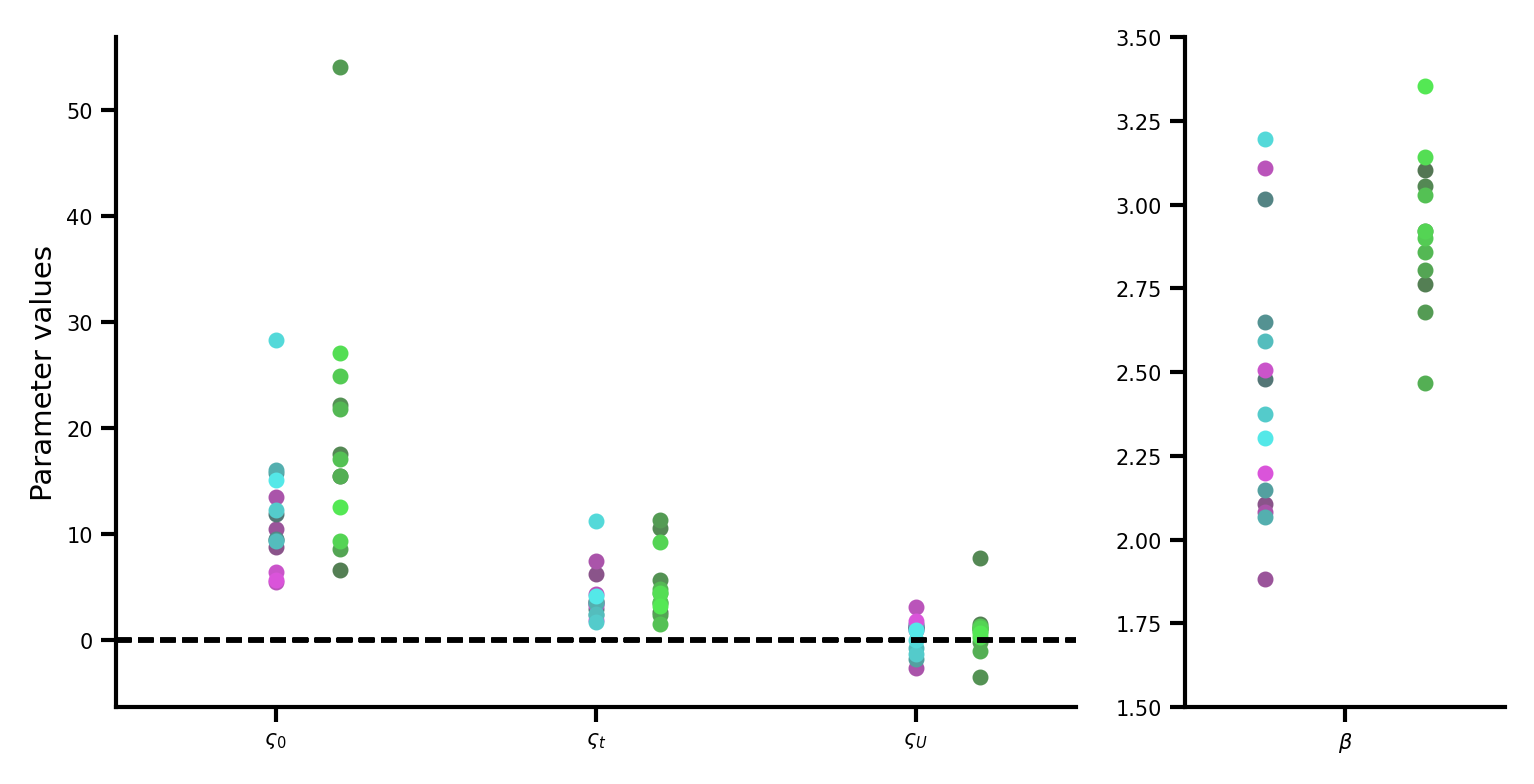

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), gridspec_kw={'width_ratios': [3, 1]})
ylabels = [r'$\varsigma_0$', r"$\varsigma_t$", r"$\varsigma_U$"]
beta = r'$\beta$'
ylims = [[-.2, 2.5], [-.05, .2], [-.15, .15],]


effort_sensitivity_0_intact = []
effort_sensitivity_t_intact = []
effort_sensitivity_U_intact = []
power_0_intact = []

effort_sensitivity_0_lesion = []
effort_sensitivity_t_lesion = []
effort_sensitivity_U_lesion = []
power_0_lesion = []

for animal in animalList:
    if animal in intact_rats:
        x = np.arange(3)
        effort_sensitivity_0_intact.append(effort_sensitivity_0[animal])
        effort_sensitivity_t_intact.append(effort_sensitivity_t[animal])
        effort_sensitivity_U_intact.append(effort_sensitivity_U[animal])
        power_0_intact.append(power_0[animal])

    else:
        x = np.arange(3) + .2
        effort_sensitivity_0_lesion.append(effort_sensitivity_0[animal])
        effort_sensitivity_t_lesion.append(effort_sensitivity_t[animal])
        effort_sensitivity_U_lesion.append(effort_sensitivity_U[animal])
        power_0_lesion.append(power_0[animal])

    axs[0].scatter(x,  [effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], s=8)
    axs[0].set_title(f"")
    axs[0].set_xticks(np.arange(3))
    axs[0].set_xticklabels(ylabels)
    axs[0].set_xlim(-.5, 2.5)
    axs[0].axhline(0, color='black', linestyle='--', linewidth=1)

    x = 0 if animal in intact_rats else 1
    axs[1].scatter(x, power_0[animal], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], s=8)
    axs[1].set_ylim(1.5, 3.5)
    axs[1].set_xticks([0.5])
    axs[1].set_xlim(-.5, 1.5)
    axs[1].set_xticklabels([beta])

axs[0].set_ylabel("Parameter values")

# Fit example session

In [69]:
animal='RatM00'
session='RatM00_2021_07_22_16_13_03'

data_run = prepare_data_running_times(sequence, [animal], [session])
data_idle = prepare_data_idle_times(sequence, [animal], [session])

In [70]:

# fit the data to the models, reload if already done
if os.path.exists("picklejar/example_session_fit_run_duration.p"):
    ex_mu, ex_sigma, ex_mu_t, ex_sigma_t, ex_mu_U, ex_sigma_U = pickle.load(open("picklejar/example_session_fit_run_duration.p", "rb"))
else:
    (ex_mu, ex_sigma, ex_mu_t, ex_sigma_t, ex_mu_U, ex_sigma_U), loss_run = modelrun_fit(data_run[animal])
    pickle.dump((ex_mu, ex_mu_t, ex_mu_U, ex_sigma, ex_sigma_t, ex_sigma_U), open("picklejar/example_session_fit_run_duration.p", 'wb'))


if os.path.exists("picklejar/example_session_fit_inter_run_duration.p"):
    ex_alpha, ex_alpha_t, ex_gamma, ex_alpha_U, ex_gamma_t, ex_gamma_U = pickle.load(open("picklejar/example_session_fit_inter_run_duration.p", 'rb'))
else:
    (ex_alpha, _, ex_gamma, ex_alpha_t, _, ex_gamma_t, ex_alpha_U, _, ex_gamma_U), loss_idle = modelwald_fit(data_idle[animal])
    pickle.dump((ex_alpha, ex_alpha_t, ex_alpha_U, ex_gamma, ex_gamma_t, ex_gamma_U), open("picklejar/example_session_fit_inter_run_duration.p", 'wb'))


print((ex_mu, ex_mu_t, ex_mu_U, ex_sigma, ex_sigma_t, ex_sigma_U))
print((ex_alpha, ex_alpha_t, ex_alpha_U, ex_gamma, ex_gamma_t, ex_gamma_U))

(1.364056803789173, -0.004086011765415236, -0.0032982158845333205, 0.06320540890720386, 0.07769265351251081, 0.014050822653490853)
(1.6749019366658602, 0.32652823486284416, 1.0650098929093814, -0.05871907890528583, -0.055303904901337214, -0.24711719272673832)
